In [4]:
import os, sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
    
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
from PIL import Image

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr, spearmanr, entropy, rankdata
from sklearn.manifold import MDS
from scipy.ndimage import gaussian_filter1d

import utils_txt as tut

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [5]:
DATA_DIR = '../../datasets/NNN/'
IMG_DIR = '../../datasets/NNN/NSD1000_LOC'

CAT = 'face'
dat = pd.read_pickle(os.path.join(DATA_DIR, (f'{CAT}_roi_data.pkl')))
ROI_LIST = list(dat['roi'].unique())
print(f'Unique face ROIs: {ROI_LIST}')

with open(f'../../datasets/NNN/{CAT}_mins.pkl', 'rb') as f:
    mins = pickle.load(f)
    
SCALES = {k: v[0] for k,v in mins.items()}

SAVE_DIR = '../../../buckets/manifold-dynamics/time-time/'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


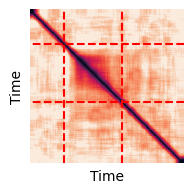

In [3]:
ROI = 'Unknown_19_F' # Unknown_19_F, MF1_7_F, MF1_8_F, MF1_9_F, AF3_18_F, MB1_3_B
MODE = 'top'
scale = -1
vmin, vmax= 0, 1
di = {-1: 'shuff', 1072: 'all'}

Rt, _ = tut.static_rdm(dat, ROI, mode=MODE, scale=scale,
                          tstart=0, tend=450)
        
fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(Rt, ax=ax, square=True, 
            vmin=vmin, vmax=vmax, cbar=False)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_ylabel('Time')

ymin, ymax = ax.get_ylim()
ax.vlines(x=100, ymin=ymin, ymax=ymax, color='red', linestyle='--')
ax.vlines(x=270, ymin=ymin, ymax=ymax, color='red', linestyle='--')

ax.hlines(y=100, xmin=ymin, xmax=ymax, color='red', linestyle='--')
ax.hlines(y=270, xmin=ymin, xmax=ymax, color='red', linestyle='--')


# plt.savefig(os.path.join(SAVE_DIR, f'{ROI}_{di[scale]}.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [13]:
ROI = 'Unknown_19_F' # Unknown_19_F, MF1_7_F, MF1_8_F, MF1_9_F, AF3_18_F, MB1_3_B
MODE = 'top'
scale = SCALES[ROI]
# 100 t0, 200 window for medial
# 150 to, 300 window for anterior
t0 = 100 
window = 300 #

Rt, _ = tut.static_rdm(dat, ROI, mode=MODE, scale=scale,
                  tstart=t0, tend=t0 + window)

print(tut.ED2(Rt))
# np.fill_diagonal(Rt, np.nan)

# Ra, _ = tut.static_rdm(dat, ROI, mode=MODE, scale=1072,
#                   tstart=t0, tend=t0 + window)

# Rss = []
# for i in tqdm(range(500)):
#     Rs, _ = static_rdm(dat, ROI, mode='shuff', scale=scale,
#                       tstart=t0, tend=t0 + window, random_state=i)
#     Rss.append(Rs)

7.828008063448615


In [57]:
ROI = 'Unknown_19_F'  # Unknown_19_F, MF1_7_F, MF1_8_F, MF1_9_F, AF3_18_F, MB1_3_B
MODE = 'top'
scale = SCALES[ROI]

T = 450
W_step = 20
# choose ranges (edit step sizes if you want finer/slower)
t0_vals = np.arange(0, 350, 10)           # start times
win_vals = np.arange(100, 300, W_step)         # window sizes (must keep t0+win <= T)

ED = np.full((len(t0_vals), len(win_vals)), np.nan, dtype=float)

for i, t0 in enumerate(tqdm(t0_vals, desc='t0')):
    for j, win in enumerate(win_vals):
        t1 = t0 + win
        if t1 > T:
            continue
        try:
            Rt, _ = tut.static_rdm(dat, ROI, mode=MODE, scale=scale, tstart=int(t0), tend=int(t1))
            ED[i, j] = tut.ED2(Rt)
        except Exception:
            # if a window fails (e.g., too few units/images), leave nan
            continue

t0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:25<00:00,  1.39it/s]


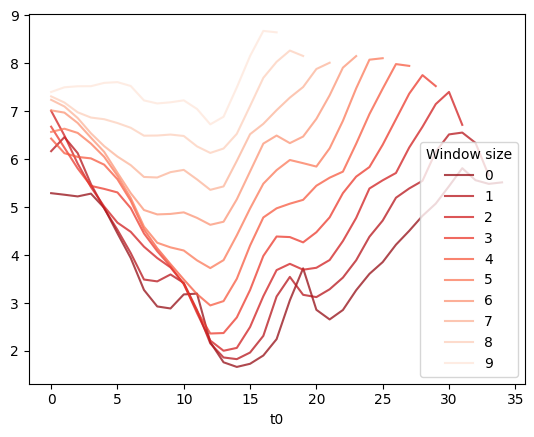

In [87]:
# ED = ED.T
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('t0')
customp = sns.color_palette('Reds_r', len(ED))

for i, t0 in enumerate(ED):
    sns.lineplot(t0, alpha=0.75, color=customp[i], label=f'{i}', ax=ax)

ax.legend(title='Window size')
plt.show()

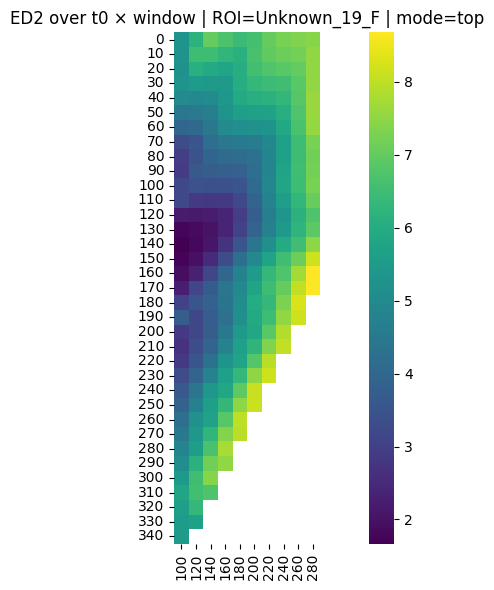

In [64]:
# heatmap: ed(t0, window)
fig, ax = plt.subplots(1, 1)
sns.heatmap(
    ED,
    ax=ax,
    square=True,
    cmap='viridis',
    xticklabels=win_vals,
    yticklabels=t0_vals
)
ax.set_title(f'ED2 over t0 × window | ROI={ROI} | mode={MODE}')
plt.tight_layout()
plt.show()

In [ ]:
for _r, scale in SCALES.items():
    order = local_scale(dat, _r, mode=MODE, scale=scale,
                      tstart=t0, tend=t0 + window)
    
    n = np.min([scale, 20])
    ncols = 5
    nrows = int(np.ceil(n / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols+1,nrows))
    axes = np.atleast_1d(axes).ravel()
    
    for ax, idx in zip(axes, order[:n]):
        fname = idx_to_fname(int(idx))
        img = Image.open(os.path.join(IMG_DIR, fname))
        ax.imshow(img, cmap='gray')
        ax.set_title(f'image {idx}', fontsize=8)
        ax.axis('off')
    
    # hide unused axes
    for ax in axes[n:]:
        ax.axis('off')
    
    fig.suptitle(f'{_r} top images')
    plt.tight_layout()
    plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
customp = sns.color_palette('rocket', as_cmap=True)
vmin, vmax = 0, 1 # np.nanmin(Rt), np.nanmax(Rt)

ax = axes[0]
sns.heatmap(Rt, vmax=vmax, vmin=vmin,
            cbar=False, square=True,# ax=ax)
            cmap=customp, ax=ax)
ax.set_axis_off()
ax.set_title(f'Top {scale}')

ax = axes[1]
sns.heatmap(Ra, vmax=vmax, vmin=vmin,
            cbar=False, square=True,# ax=ax)
            cmap=customp, ax=ax)
ax.set_axis_off()
ax.set_title('Global Span')

In [ ]:
### PLOT in specific window
for _r in ROI_LIST:
    for _m in ['top', 'shuff']:
        scale = SCALES[_r]
        vmin, vmax= 0, 1
        Rt, _ = tut.static_rdm(dat, _r, mode=_m, scale=scale,
                          tstart=100, tend=350)
        
        fig, ax = plt.subplots(figsize=(2, 2))
        sns.heatmap(Rt, ax=ax, square=True, 
                    vmin=vmin, vmax=vmax, cbar=False)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Time')
        
        plt.savefig(os.path.join(SAVE_DIR, 'window', f'{_r}_{_m}.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()

In [ ]:
Vt = tut.rdv(Rt)
Va = tut.rdv(Ra)

# collect effective dimensionalities
Rs_EDs = np.array([tut.ED2(Rs) for Rs in Rss])

conditions = [f'T{scale}', 'S30', 'All']

# build long-form dataframe so seaborn can handle stats + errorbars
rows = []

rows.append({'cond': conditions[0], 'ed': tut.ED2(Rt), 'kind': 'test'})
for v in Rs_EDs:
    rows.append({'cond': conditions[1], 'ed': v, 'kind': 'shuffle'})
rows.append({'cond': conditions[2], 'ed': tut.ED2(Ra), 'kind': 'all'})

df = pd.DataFrame(rows)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# bars (median + sd errorbars)
sns.barplot(
    data=df,
    x='cond',
    y='ed',
    order=conditions,
    estimator=np.median,
    errorbar='sd', errcolor='black',
    palette=['red', 'blue', 'gray'],
    ax=ax,
    zorder=1
)

# dots for the shuffle distribution (middle bar only)
sns.stripplot(
    data=df[df['cond'] == conditions[1]],
    x='cond',
    y='ed',
    order=conditions,
    color='black',
    size=2,
    jitter=0.2,
    alpha=0.1,
    ax=ax,
    zorder=2
)

ax.set_title(f'{ROI} dynamics ({t0}-{t0+window} msec)')
ax.set_xlabel('image manifold scale')
ax.set_ylabel('effective dimensionality')

sns.despine(fig, trim=True, offset=5)
plt.tight_layout()

In [ ]:
for ROI, SC in mins.items():
# for ROI in ['MB3_12_B', 'AB3_12_B', 'AB3_17_B', 'Unknown_27_B']: # not converging for: 'MB1_8_B', 'AB3_18_B',
    # SC = mins[ROI]
    scale = SC[0]
    
    MODE = 'top'
    # 100 t0, 200 window for medial
    # 150 to, 300 window for anterior
    t0 = 100 
    window = 200 #
    
    Rt, _ = static_rdm(dat, ROI, mode=MODE, scale=scale,
                      tstart=t0, tend=t0 + window)
    
    Ra, _ = static_rdm(dat, ROI, mode=MODE, scale=1072,
                      tstart=t0, tend=t0 + window)
    
    Rss = []
    for i in tqdm(range(500)):
        Rs, _ = static_rdm(dat, ROI, mode='shuff', scale=scale,
                          tstart=t0, tend=t0 + window, random_state=i)
        Rss.append(Rs)
    
    Vt = rdv(Rt)
    Va = rdv(Ra)

    try:
        # collect effective dimensionalities
        Rs_EDs = np.array([ED2(Rs) for Rs in Rss])
    except:
        Rs_EDs = [np.nan for _ in Rss]
        print(f'eigenvalues do not converge for ROI: {ROI}')
        
    conditions = [f'T{scale}', 'S30', 'All']
    
    # build long-form dataframe so seaborn can handle stats + errorbars
    rows = []
    
    rows.append({'cond': conditions[0], 'ed': ED2(Rt), 'kind': 'test'})
    for v in Rs_EDs:
        rows.append({'cond': conditions[1], 'ed': v, 'kind': 'shuffle'})
    rows.append({'cond': conditions[2], 'ed': ED2(Ra), 'kind': 'all'})
    
    df = pd.DataFrame(rows)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # bars (median + sd errorbars)
    sns.barplot(
        data=df,
        x='cond',
        y='ed',
        order=conditions,
        estimator=np.median,
        errorbar='sd', errcolor='black',
        palette=['red', 'blue', 'gray'],
        ax=ax,
        zorder=1
    )
    
    # dots for the shufsfle distribution (middle bar only)
    sns.stripplot(
        data=df[df['cond'] == conditions[1]],
        x='cond',
        y='ed',
        order=conditions,
        color='black',
        size=2,
        jitter=0.2,
        alpha=0.1,
        ax=ax,
        zorder=2
    )
    
    ax.set_title(f'{ROI} dynamics ({t0}-{t0+window} msec)')
    ax.set_xlabel('image manifold scale')
    ax.set_ylabel('effective dimensionality')
    
    sns.despine(fig, trim=True, offset=5)
    plt.tight_layout()
    plt.show()